In [1]:
# run stopwatch
from tools import Stopwatch
stopwatch = Stopwatch()
start = stopwatch.start()

### Load libraries, functions, palette, theme

In [2]:
%run _libraries.ipynb

In [3]:
%run _functions.ipynb

In [4]:
save_files = 'files/Section1-Overview-and-Base-model'

In [5]:
save_img = 'docs/img/Section1-Overview-and-Base-model'

In [6]:
session_name = 'Section1-Overview-and-Base-model'

# Section I. Overview

## Load Saved Section if exists

## Load Data

In [7]:
data = pd.read_csv('data/train.csv')

In [8]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
data.shape

(1460, 81)

#### Check duplicates

In [10]:
data[data.duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


## Data Split

#### Train and Test datasets

In [11]:
train, test = train_test_split(
    data, test_size=0.1, random_state=seed)

In [12]:
train.shape

(1314, 81)

In [13]:
test.shape

(146, 81)

## Data Overview

#### Dataset

In [14]:
train.shape

(1314, 81)

In [15]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
907,908,50,RL,86.0,11500,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,250000
782,783,20,RL,67.0,16285,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,187100
952,953,85,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,133900
620,621,30,RL,45.0,8248,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,67000
669,670,30,RL,80.0,11600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,137500


In [16]:
train = train.rename(columns={'SalePrice': 'price'})
test = test.rename(columns={'SalePrice': 'price'})

train.columns = map(str.lower, train.columns)

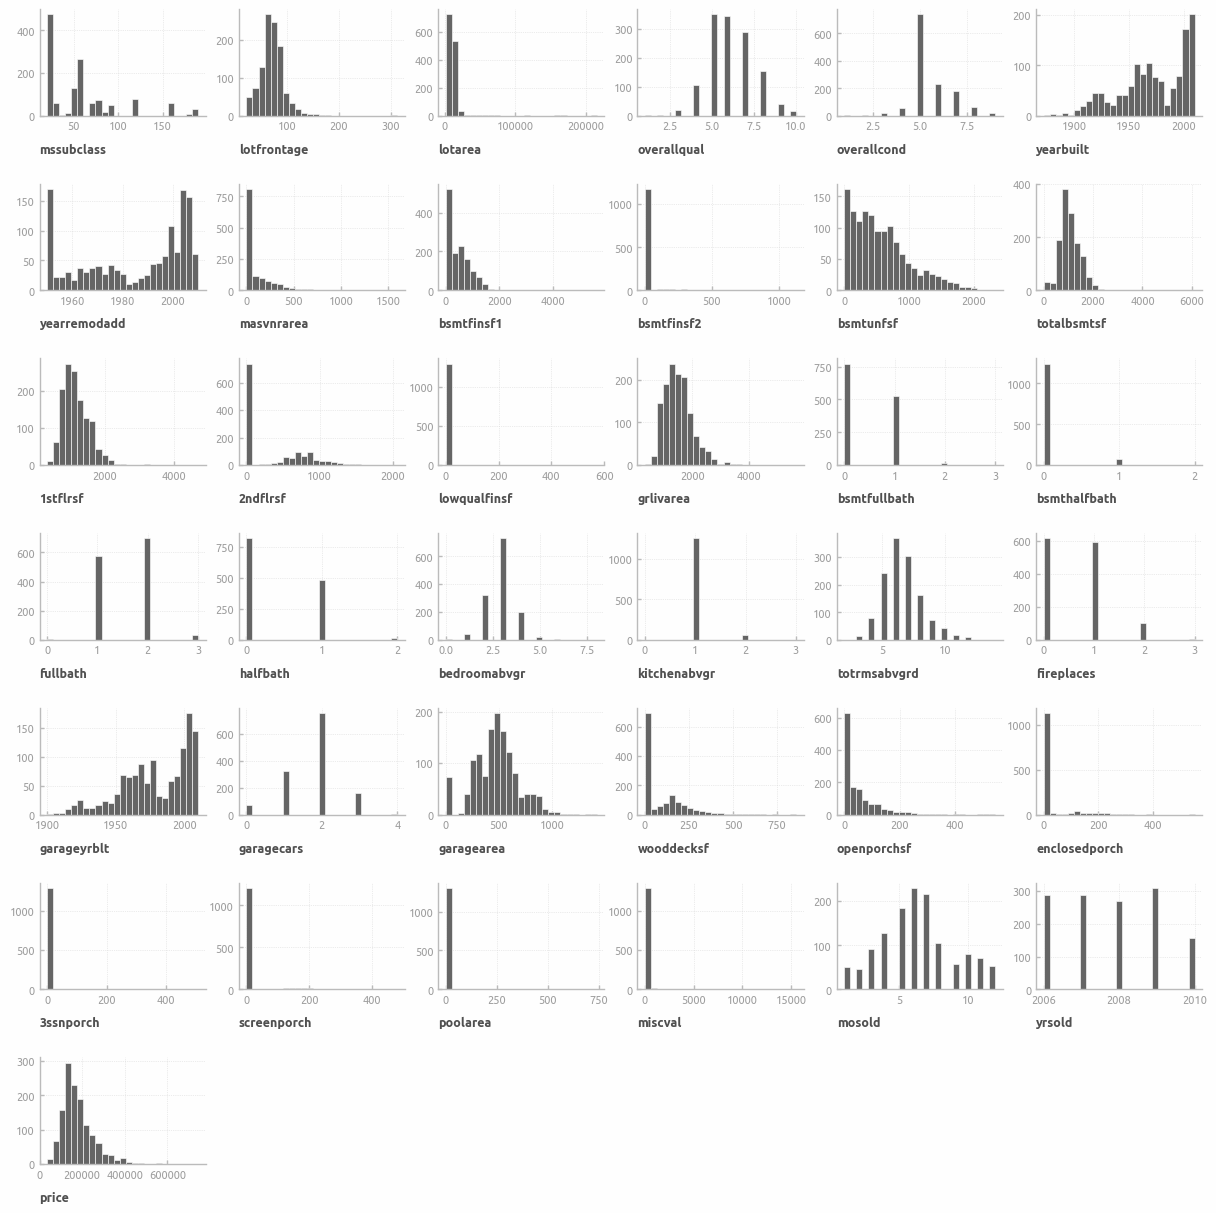

In [17]:
columns_plot = (train
                .drop('id', axis=1)
                .select_dtypes(np.number)
                .columns.tolist())
f = plot_gridplot(
    data=train,
    features=columns_plot,
    figsize=(15,15),
    ncols=6,
    kind='hist',
    plot_shape='rectangle',
    hscale=1.6,
    histplot_kwargs={'bins': 25})

In [18]:
train.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,price
count,1314.000000,1314.000000,1077.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1306.000000,1314.000000,...,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,733.098174,57.431507,69.793872,10618.920091,6.107306,5.576865,1971.008371,1984.819635,103.800919,445.867580,...,94.875951,47.885084,22.132420,3.770928,15.258752,3.065449,46.677321,6.344749,2007.819635,180704.734399
std,422.655559,42.510304,24.406605,10423.889109,1.373747,1.109653,30.462154,20.696263,177.101513,455.366534,...,126.785144,67.500696,61.865423,30.876730,56.303822,42.341109,522.035539,2.689126,1.334484,77436.784729
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.250000,20.000000,59.000000,7560.000000,5.000000,5.000000,1953.250000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,735.500000,50.000000,69.000000,9549.500000,6.000000,5.000000,1972.000000,1994.000000,0.000000,387.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,164500.000000
75%,1095.500000,70.000000,80.000000,11622.750000,7.000000,6.000000,2001.000000,2004.000000,164.750000,719.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,745000.000000


In [19]:
train.describe(include=object)

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
count,1314,1314,86,1314,1314,1314,1314,1314,1314,1314,...,1241,1241,1241,1241,1314,7,252,50,1314,1314
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1039,1309,49,828,1182,1313,941,1243,201,1128,...,776,542,1178,1190,1201,3,141,45,1140,1079


#### Columns rename to prevent Statsmodels errors

In [20]:
print(sorted(train.columns.to_list(), key=str.lower))

['1stflrsf', '2ndflrsf', '3ssnporch', 'alley', 'bedroomabvgr', 'bldgtype', 'bsmtcond', 'bsmtexposure', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtfintype1', 'bsmtfintype2', 'bsmtfullbath', 'bsmthalfbath', 'bsmtqual', 'bsmtunfsf', 'centralair', 'condition1', 'condition2', 'electrical', 'enclosedporch', 'extercond', 'exterior1st', 'exterior2nd', 'exterqual', 'fence', 'fireplacequ', 'fireplaces', 'foundation', 'fullbath', 'functional', 'garagearea', 'garagecars', 'garagecond', 'garagefinish', 'garagequal', 'garagetype', 'garageyrblt', 'grlivarea', 'halfbath', 'heating', 'heatingqc', 'housestyle', 'id', 'kitchenabvgr', 'kitchenqual', 'landcontour', 'landslope', 'lotarea', 'lotconfig', 'lotfrontage', 'lotshape', 'lowqualfinsf', 'masvnrarea', 'masvnrtype', 'miscfeature', 'miscval', 'mosold', 'mssubclass', 'mszoning', 'neighborhood', 'openporchsf', 'overallcond', 'overallqual', 'paveddrive', 'poolarea', 'poolqc', 'price', 'roofmatl', 'roofstyle', 'salecondition', 'saletype', 'screenporch', 'street', 't

In [21]:
train = rename_columns(train)
test = rename_columns(test)

In [22]:
train_raw = train.copy()

In [23]:
print(sorted(train.columns.to_list(), key=str.lower))

['alley', 'bedroomabvgr', 'bldgtype', 'bsmtcond', 'bsmtexposure', 'bsmtfinsf_first', 'bsmtfinsf_second', 'bsmtfintype_first', 'bsmtfintype_second', 'bsmtfullbath', 'bsmthalfbath', 'bsmtqual', 'bsmtunfsf', 'centralair', 'condition_first', 'condition_second', 'electrical', 'enclosedporch', 'extercond', 'exterior_first', 'exterior_second', 'exterqual', 'fence', 'fireplacequ', 'fireplaces', 'first_flrsf', 'foundation', 'fullbath', 'functional', 'garagearea', 'garagecars', 'garagecond', 'garagefinish', 'garagequal', 'garagetype', 'garageyrblt', 'grlivarea', 'halfbath', 'heating', 'heatingqc', 'housestyle', 'id', 'kitchenabvgr', 'kitchenqual', 'landcontour', 'landslope', 'lotarea', 'lotconfig', 'lotfrontage', 'lotshape', 'lowqualfinsf', 'masvnrarea', 'masvnrtype', 'miscfeature', 'miscval', 'mosold', 'mssubclass', 'mszoning', 'neighborhood', 'openporchsf', 'overallcond', 'overallqual', 'paveddrive', 'poolarea', 'poolqc', 'price', 'roofmatl', 'roofstyle', 'salecondition', 'saletype', 'screenpo

#### Creating variables lists

In [24]:
# target variable
target = 'price'

In [25]:
ordinal = [
    'overallcond', 'overallqual', 'exterqual', 'extercond', 'bsmtqual',
    'bsmtcond', 'heatingqc', 'kitchenqual', 'fireplacequ', 'garagecond',
    'garagequal', 'poolqc', 'bsmtexposure', 'bsmtfintype_first',
    'bsmtfintype_second', 'functional', 'garagetype', 'garagefinish'
]

In [26]:
# numeric variables
numeric = (train
           .drop(['id', 'price'], axis=1)
           .select_dtypes(include=['int64', 'float64'])
           .columns.tolist())
# remove ordinal variables from numeric list
numeric = [i for i in numeric if i not in ordinal]

In [27]:
# categorical variables
categorical = (train
               .drop(['id', 'price'], axis=1)
               .select_dtypes(include=['object', 'bool'])
               .columns.tolist())
categorical = [i for i in categorical if i not in ordinal]

In [28]:
# features
features = numeric + ordinal + categorical

In [29]:
data_raw_features_len = len(data.drop('Id', axis=1).columns)
assert 0 == (data_raw_features_len
             - len(numeric)
             - len(ordinal)
             - len(categorical)
             - len([target]))

In [30]:
len(numeric)

34

In [31]:
print(numeric)

['mssubclass', 'lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf_first', 'bsmtfinsf_second', 'bsmtunfsf', 'totalbsmtsf', 'first_flrsf', 'second_flrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'three_ssnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold']


In [32]:
len(ordinal)

18

In [33]:
print(ordinal)

['overallcond', 'overallqual', 'exterqual', 'extercond', 'bsmtqual', 'bsmtcond', 'heatingqc', 'kitchenqual', 'fireplacequ', 'garagecond', 'garagequal', 'poolqc', 'bsmtexposure', 'bsmtfintype_first', 'bsmtfintype_second', 'functional', 'garagetype', 'garagefinish']


In [34]:
len(categorical)

27

In [35]:
print(categorical)

['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition_first', 'condition_second', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior_first', 'exterior_second', 'masvnrtype', 'foundation', 'heating', 'centralair', 'electrical', 'paveddrive', 'fence', 'miscfeature', 'saletype', 'salecondition']


In [36]:
target

'price'

#### Target Variable

In [37]:
train[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
price,1314.0,180704.734399,77436.784729,34900.0,130000.0,164500.0,214000.0,745000.0


In [38]:
train_target_raw = train[target].copy()

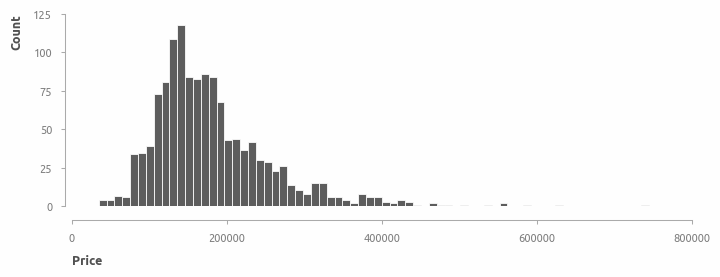

Images 'target_distribution.png' and 'target_distribution.svg' successfully saved into 'docs/img/Section1-Overview-and-Base-model' directory


In [39]:
fig = plt.figure()
sns.histplot(train_target_raw, bins=70, alpha=1)
plt.xlabel('Price')
plt.ylabel('Count')
# plt.title('Distribution of Price')
plt.grid(False)
axis_rstyle(xticks=(0, 800000, 200000), yticks=(0, 125, 25))
plt.show()

savefig('target_distribution', save_img)

In [40]:
train[target] = np.log(train[target])

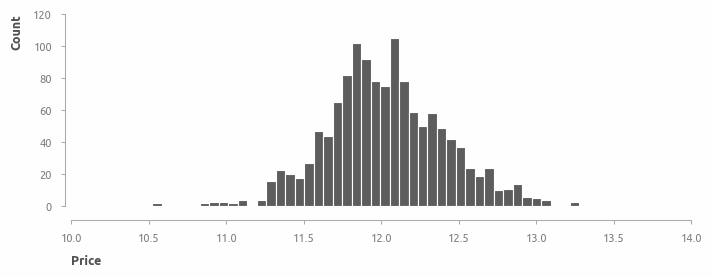

Images 'target_distribution_log.png' and 'target_distribution_log.svg' successfully saved into 'docs/img/Section1-Overview-and-Base-model' directory


In [41]:
fig = plt.figure()
sns.histplot(data=train, x=target, bins=50, alpha=1)
plt.xlabel('Price')
plt.ylabel('Count')
# plt.title('Distribution of Price')
plt.grid(False)
axis_rstyle(xticks=(10.0, 14.0, 0.5), yticks=(0, 120, 20))
plt.gca().tick_params(direction='out')
plt.show()

savefig('target_distribution_log', save_img)

## Missing Values Handling

### Categorical variables

#### Manually NaNs handling with data description

In [42]:
data_describe(train[ordinal]).head()

,Type,Count,Unique,NaN,Percentages
poolqc,object,7,3,1307,99
fireplacequ,object,698,5,616,47
garagecond,object,1241,5,73,6
garagetype,object,1241,6,73,6
garagequal,object,1241,5,73,6


In [43]:
data_describe(train[categorical]).head()

,Type,Count,Unique,NaN,Percentages
miscfeature,object,50,4,1264,96
alley,object,86,2,1228,93
fence,object,252,4,1062,81
masvnrtype,object,542,3,772,59
electrical,object,1313,4,1,0


##### Variables with 'NA' as NaN values (as in 'Data Description'):  
'poolqc', 'miscfeature', 'alley', 'fence', 'masvnrtype', 'fireplacequ', 'garagecond', 'garagetype', 'garagequal', 'garagefinish', 'garageyrbuilt', 'bsmtexposure', 'bsmtqual', 'bsmtcond', 'bsmtfintype1', 'bsmtfintype2'

In [44]:
features_na = [
    'poolqc', 'miscfeature', 'alley', 'fence',
    'masvnrtype', 'fireplacequ', 'garagecond', 
    'garagetype', 'garagequal', 'garagefinish',
    'bsmtexposure', 'bsmtqual', 'bsmtcond',
    'bsmtfintype_first', 'bsmtfintype_second'
]

In [45]:
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price
907,908,50,RL,86.0,11500,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,12.429216
782,783,20,RL,67.0,16285,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,12.139399
952,953,85,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,11.804849
620,621,30,RL,45.0,8248,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,11.112448
669,670,30,RL,80.0,11600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,11.831379


In [46]:
train[features_na] = train[features_na].fillna('NA')

In [47]:
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price
907,908,50,RL,86.0,11500,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,6,2006,WD,Normal,12.429216
782,783,20,RL,67.0,16285,Pave,NA,IR2,Lvl,AllPub,...,0,NA,NA,NA,0,6,2009,WD,Normal,12.139399
952,953,85,RL,60.0,7200,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,4,2009,WD,Normal,11.804849
620,621,30,RL,45.0,8248,Pave,Grvl,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,11.112448
669,670,30,RL,80.0,11600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,7,2006,WD,Normal,11.831379


In [48]:
data_describe(train[categorical]).head()

,Type,Count,Unique,NaN,Percentages
electrical,object,1313,4,1,0
mszoning,object,1314,5,0,0
roofmatl,object,1314,8,0,0
saletype,object,1314,9,0,0
miscfeature,object,1314,5,0,0


#### Categorical Imputation

Most frequent. <br>
The only NaN value of 'electrical' variable is filled by the most frequent value

In [49]:
imputer_frequent = CategoricalImputer(
    imputation_method='frequent',
    variables=categorical
)

In [50]:
imputer_frequent.fit(train)

CategoricalImputer(imputation_method='frequent',
                   variables=['mszoning', 'street', 'alley', 'lotshape',
                              'landcontour', 'utilities', 'lotconfig',
                              'landslope', 'neighborhood', 'condition_first',
                              'condition_second', 'bldgtype', 'housestyle',
                              'roofstyle', 'roofmatl', 'exterior_first',
                              'exterior_second', 'masvnrtype', 'foundation',
                              'heating', 'centralair', 'electrical',
                              'paveddrive', 'fence', 'miscfeature', 'saletype',
                              'salecondition'])

In [51]:
train = imputer_frequent.transform(train)

In [52]:
data_describe(train[categorical]).head(5)

,Type,Count,Unique,NaN,Percentages
mszoning,object,1314,5,0,0
roofmatl,object,1314,8,0,0
saletype,object,1314,9,0,0
miscfeature,object,1314,5,0,0
fence,object,1314,5,0,0


In [53]:
train[categorical].isna().values.any()

False

### Quantitative variables

In [54]:
data_describe(train[numeric]).head(5)

,Type,Count,Unique,NaN,Percentages
lotfrontage,float64,1077,108,237,18
garageyrblt,float64,1241,95,73,6
masvnrarea,float64,1306,306,8,1
wooddecksf,int64,1314,260,0,0
kitchenabvgr,int64,1314,4,0,0


#### 'garageyrblt' 

Filling NaN values by 'yearbuilt' value

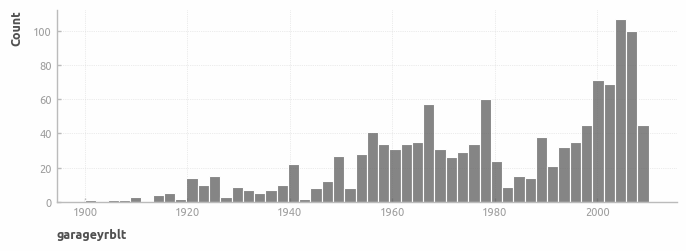

In [55]:
sns.histplot(train['garageyrblt'], bins=50);

In [56]:
garage_fill = train.loc[train['garageyrblt'].isna(), 'yearbuilt']

In [57]:
loc = train['garageyrblt'].isna(), 'garageyrblt'
train.loc[loc] = train.loc[loc].fillna(garage_fill)

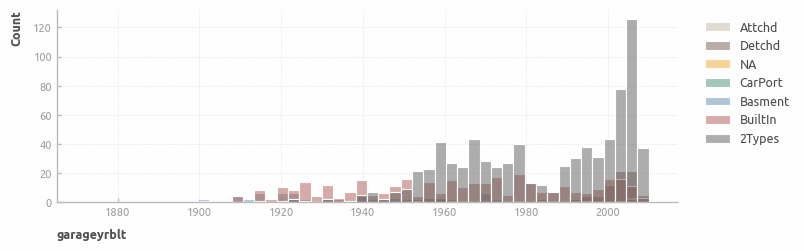

In [58]:
sns.histplot(
    data=train, x='garageyrblt',
    hue='garagetype', bins=50
);
plt.legend(
    labels = train['garagetype'].unique(),
    loc='upper right', bbox_to_anchor=(1.2, 1),
    prop={'size': 9}, labelcolor='0.3' 
)
plt.show()

#### 'lotfrontage'

1. Check is there dependency between 'lotfrontage'==NaN and target

**Results:** 
1. no dependency **-->** mean imputation
2. Additional: detected two potential outliers (idxs: 934, 1298)

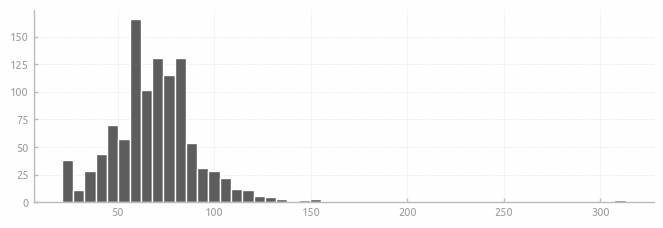

In [59]:
train['lotfrontage'].hist(bins=50);

In [60]:
(train[numeric]
 .corr()
 .loc['lotfrontage']
 .sort_values(ascending=False, key=abs)
 .head())

lotfrontage    1.000000
first_flrsf    0.453377
lotarea        0.416208
grlivarea      0.391220
mssubclass    -0.388721
Name: lotfrontage, dtype: float64

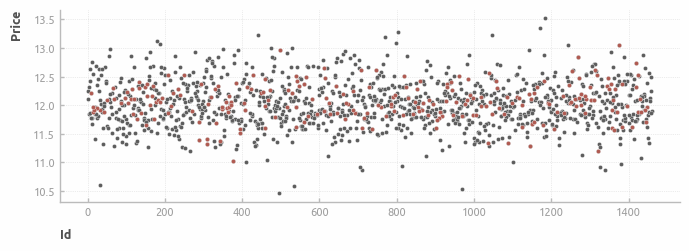

In [61]:
# lotfrontage NaNs range in 'price' variable
fig = plt.figure()
sns.scatterplot(
    data=train,
    x='id',
    y=target,
    color=palette[0]
)
loc_r = train['lotfrontage'].isna()
sns.scatterplot(
    data=train.loc[loc_r],
    y='price',
    x=train.loc[loc_r, 'id'].values,
    color=palette[1]
)
plt.xlabel(str.capitalize('id'))
plt.ylabel(str.capitalize('price'))
plt.show()

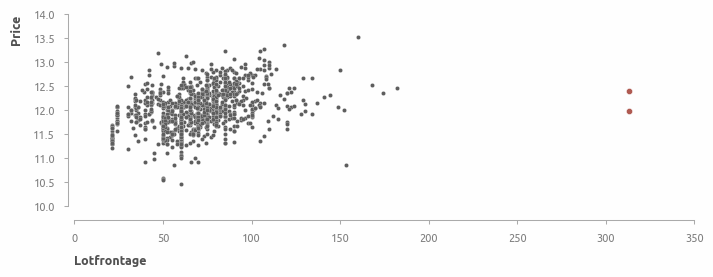

Images 'lotfrontage_outs.png' and 'lotfrontage_outs.svg' successfully saved into 'docs/img/Section1-Overview-and-Base-model' directory


In [62]:
fig = plt.figure(figsize=(8, 2.5))

sns.scatterplot(
    data=train, x='lotfrontage', y=target, **scatter)

sns.scatterplot(
    data=train.loc[train['lotfrontage']>250, ['lotfrontage', target]],
    x='lotfrontage',
    y=target,
    s=20,
    color=palette[1])

plt.xlabel('Lotfrontage')
plt.ylabel('Price')
# plt.title('Street connected to property vs Price')
axis_rstyle(
    yticks=[10, 14, 0.5],
    xticks=[0, 350, 50],
    grid=False
)
plt.show()

savefig('lotfrontage_outs', save_img)

In [63]:
train[train['lotfrontage']>250]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price
1298,1299,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,11.982929
934,935,20,RL,313.0,27650,Pave,NA,IR2,HLS,AllPub,...,0,NA,NA,NA,0,11,2008,WD,Normal,12.396693


#### 'masvnrarea'

Potential outliers (idx: 297)

In [64]:
masvnrarea_nan_idxs = train[train['masvnrarea'].isna()].index.tolist()

In [65]:
masvnrarea_nan_idxs

[529, 1243, 936, 973, 650, 1278, 234, 977]

In [66]:
train.loc[masvnrarea_nan_idxs, ['masvnrarea', 'masvnrtype', 'price']]

,masvnrarea,masvnrtype,price
529,NaN,NA,12.209188
1243,NaN,NA,13.049793
936,NaN,NA,12.127570
973,NaN,NA,12.111762
650,NaN,NA,12.235389
1278,NaN,NA,12.375815
234,NaN,NA,12.285346
977,NaN,NA,12.205573


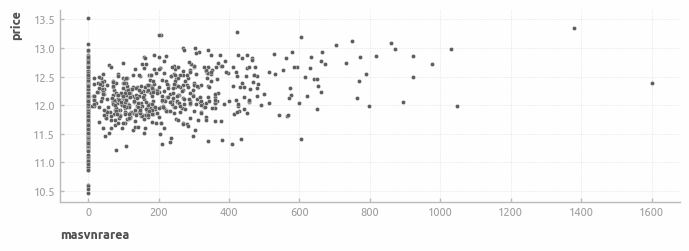

In [67]:
sns.scatterplot(data=train, x='masvnrarea', y=target);

In [68]:
train[train['masvnrarea'] > 1400]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price
297,298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,6,2007,WD,Normal,12.384219


In [69]:
train.loc[train['masvnrarea'].isna(), 'masvnrarea'] = 0

#### Quantitative Imputation 

Median

In [70]:
imputer_median = MeanMedianImputer(
    imputation_method='median',
    variables=numeric
)

In [71]:
imputer_median.fit(train)

MeanMedianImputer(variables=['mssubclass', 'lotfrontage', 'lotarea',
                             'yearbuilt', 'yearremodadd', 'masvnrarea',
                             'bsmtfinsf_first', 'bsmtfinsf_second', 'bsmtunfsf',
                             'totalbsmtsf', 'first_flrsf', 'second_flrsf',
                             'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
                             'bsmthalfbath', 'fullbath', 'halfbath',
                             'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
                             'fireplaces', 'garageyrblt', 'garagecars',
                             'garagearea', 'wooddecksf', 'openporchsf',
                             'enclosedporch', 'three_ssnporch', 'screenporch', ...])

In [72]:
train = imputer_median.transform(train)

In [73]:
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price
907,908,50,RL,86.0,11500,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,6,2006,WD,Normal,12.429216
782,783,20,RL,67.0,16285,Pave,NA,IR2,Lvl,AllPub,...,0,NA,NA,NA,0,6,2009,WD,Normal,12.139399
952,953,85,RL,60.0,7200,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,4,2009,WD,Normal,11.804849
620,621,30,RL,45.0,8248,Pave,Grvl,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,11.112448
669,670,30,RL,80.0,11600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,7,2006,WD,Normal,11.831379


In [74]:
data_describe(train[numeric]).head()

,Type,Count,Unique,NaN,Percentages
mssubclass,int64,1314,15,0,0
wooddecksf,int64,1314,260,0,0
kitchenabvgr,int64,1314,4,0,0
totrmsabvgrd,int64,1314,12,0,0
fireplaces,int64,1314,4,0,0


In [75]:
train[numeric].isna().values.any()

False

## Relabeling 

In [76]:
features_labels_lists = [
    ['exterqual', 'extercond', 'bsmtqual', 'bsmtcond', 'heatingqc',
     'kitchenqual', 'fireplacequ', 'garagecond', 'garagequal', 'poolqc'],
    ['bsmtexposure'],
    ['bsmtfintype_first', 'bsmtfintype_second'],
    ['functional'],
    ['garagetype'],
    ['garagefinish'],
    ['mssubclass']
]

In [77]:
features_labels_dicts = [
    {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
    {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
    {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2,
     'Sev': 1, 'Sal': 0},
    {'2Types': 6, 'Attchd': 5, 'Basment': 4, 'BuiltIn': 3,
     'CarPort': 2, 'Detchd': 1, 'NA': 0},
    {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
]

In [78]:
train['exterqual'].unique()

array(['Gd', 'TA', 'Fa', 'Ex'], dtype=object)

In [79]:
train['poolqc'].unique()

array(['NA', 'Gd', 'Fa', 'Ex'], dtype=object)

In [80]:
train['mssubclass'].unique()

array([ 50,  20,  85,  30,  60,  90,  70,  45, 160,  80, 120, 190, 180,
        40,  75])

In [81]:
zip_ = zip(features_labels_lists, features_labels_dicts)
for lst, dct in zip_:
    for f in lst:
        train[f] = train[f].map(dct)

In [82]:
train['mssubclass'] = train['mssubclass'].apply(lambda x: str(x))

In [83]:
train['exterqual'].unique()

array([4, 3, 2, 5])

In [84]:
train['poolqc'].unique()

array([0, 4, 2, 5])

In [85]:
train['mssubclass'].unique()

array(['50', '20', '85', '30', '60', '90', '70', '45', '160', '80', '120',
       '190', '180', '40', '75'], dtype=object)

### Transform 'msubclass' values and move it to Categorical variables list

In [86]:
categorical.append('mssubclass')
numeric.remove('mssubclass')

In [87]:
assert len(features) == len(numeric) + len(ordinal) + len(categorical)

In [88]:
categorical_transform = categorical.copy()

## Transformation Pipeline Check

In [89]:
transformer_overview = OverviewTransformer(
    features_na=features_na
)

In [90]:
transformer_label = LabelTransformer(
    features_labels_lists=features_labels_lists,
    features_labels_dicts=features_labels_dicts
)

In [91]:
pipeline = Pipeline(steps=[
    ('overview', transformer_overview),
    ('imputer_num', imputer_median),
    ('imputer_cat', imputer_frequent),
    ('label', transformer_label)
])

In [92]:
pipeline

Pipeline(steps=[('overview', <tools.OverviewTransformer object at 0x1290ffad0>),
                ('imputer_num',
                 MeanMedianImputer(variables=['lotfrontage', 'lotarea',
                                              'yearbuilt', 'yearremodadd',
                                              'masvnrarea', 'bsmtfinsf_first',
                                              'bsmtfinsf_second', 'bsmtunfsf',
                                              'totalbsmtsf', 'first_flrsf',
                                              'second_flrsf', 'lowqualfinsf',
                                              'grlivarea', 'bsmtfullbath',
                                              'bsmthalfbath', 'fullbath',
                                              'halfb...
                                               'utilities', 'lotconfig',
                                               'landslope', 'neighborhood',
                                               'condition_first',
                                               'condition_second', 'bldgtype',
                                               'housestyle', 'roofstyle',
                                               'roofmatl', 'exterior_first',
                                               'exterior_second', 'masvnrtype',
                                               'foundation', 'heating',
                                               'centralair', 'electrical',
                                               'paveddrive', 'fence',
                                               'miscfeature', 'saletype',
                                               'salecondition',
                                               'mssubclass'])),
                ('label', <tools.LabelTransformer object at 0x128ac0dd0>)])

In [93]:
train_transformed = train_raw.copy()

In [94]:
train_transformed = pipeline.transform(train_transformed)

In [95]:
train_transformed[target] = np.log(train_transformed[target])

In [96]:
# check pipeline - datasets have to be equals if pipeline if correct
assert train_transformed.equals(train)

In [97]:
# display rows with differences
train[~train.apply(tuple, 1).isin(train_transformed.apply(tuple, 1))]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price


## Baseline Model

In [98]:
train_bm = train.copy()

In [99]:
train_bm.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price
907,908,50,RL,86.0,11500,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,0,6,2006,WD,Normal,12.429216
782,783,20,RL,67.0,16285,Pave,NA,IR2,Lvl,AllPub,...,0,0,NA,NA,0,6,2009,WD,Normal,12.139399
952,953,85,RL,60.0,7200,Pave,NA,Reg,Lvl,AllPub,...,0,0,MnPrv,NA,0,4,2009,WD,Normal,11.804849
620,621,30,RL,45.0,8248,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,NA,NA,0,9,2008,WD,Normal,11.112448
669,670,30,RL,80.0,11600,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,NA,0,7,2006,WD,Normal,11.831379


### Pipeline For GridSearch

In [100]:
encoder = OrdinalEncoder(
    encoding_method='ordered',
    variables=categorical_transform,
    missing_values='ignore',
    unseen='encode'
)

In [101]:
lgb1 = LGBMRegressor()

In [102]:
lgb_pipeline1 = Pipeline(steps=[
    ('encoder', encoder),
    ('estimator', lgb1)
])

### GridSearch Iteration #1

In [103]:
params1 = {
    'estimator__n_estimators': [25, 50, 75],
    'estimator__max_depth': [3, 6, 9],
    'estimator__num_leaves': [5, 38, 300],
    'estimator__learning_rate': [0.1, 0.3],
    'estimator__random_state': [seed],
    'estimator__verbose': [-1]
}

In [104]:
n_folds1 = 20

In [105]:
cv1 = GridSearchCV(
    estimator=lgb_pipeline1, 
    param_grid=params1,
    scoring='neg_root_mean_squared_error',
    cv=n_folds1
)

In [106]:
st = stopwatch.start()
cv1.fit(train_bm[features], train_bm[target])
print(f'Execution time: {stopwatch.stop(st)}')

Execution time: 0:04:04


In [107]:
cv1_results_df = pd.DataFrame(cv1.cv_results_)

In [108]:
cv1_results_df.shape

(54, 34)

In [109]:
cv1_results_df_columns_drop = [
    'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
]

In [110]:
cv1_results_df = cv1_results_df.loc[
    :, ~cv1_results_df.columns.isin(cv1_results_df_columns_drop)].copy()

In [111]:
cv1_results_df = cv1_results_df.sort_values([
    'param_estimator__learning_rate', 'param_estimator__n_estimators',
    'param_estimator__max_depth', 'param_estimator__num_leaves'
], ascending=True)

In [112]:
cv1_results_df = cv1_results_df.reset_index(drop=True)

In [113]:
# folds scores are normal
test_normality(cv1_results_df.iloc[0, 7:27].astype(float))

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),0.3936,Normal
2,Shapiro-Wilk,0.2169,Normal
3,Jarque-Bera,0.1730,Normal
4,D’Agostino-Pearson,0.0515,Normal


In [114]:
cv1_results_df['ci_margin'] = \
    1.96 * cv1_results_df['std_test_score']  / np.sqrt(n_folds1)

In [115]:
cv1_results_df_params_cols = [
    'param_estimator__learning_rate', 'param_estimator__n_estimators',
    'param_estimator__max_depth', 'param_estimator__num_leaves'
]

In [116]:
cv1_results_df.head()

,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__n_estimators,param_estimator__num_leaves,param_estimator__random_state,param_estimator__verbose,params,split0_test_score,split1_test_score,split2_test_score,...,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score,ci_margin
0,0.1,3,25,5,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.199497,-0.178385,-0.115625,...,-0.144688,-0.152249,-0.141375,-0.173079,-0.118181,-0.143023,-0.161343,0.029907,52,0.013107
1,0.1,3,25,38,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.189989,-0.164659,-0.114555,...,-0.135520,-0.149818,-0.138077,-0.167183,-0.108488,-0.126376,-0.153624,0.028702,50,0.012579
2,0.1,3,25,300,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.189989,-0.164659,-0.114555,...,-0.135520,-0.149818,-0.138077,-0.167183,-0.108488,-0.126376,-0.153624,0.028702,50,0.012579
3,0.1,6,25,5,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.199497,-0.178385,-0.115625,...,-0.145264,-0.153843,-0.141375,-0.173079,-0.118181,-0.143023,-0.161452,0.029868,53,0.013090
4,0.1,6,25,38,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.175696,-0.142110,-0.110987,...,-0.129136,-0.126381,-0.123288,-0.162059,-0.099800,-0.111415,-0.140312,0.026451,48,0.011593


In [117]:
# sort thw simplest model if several equal mean_test_scores
cv1_results_df_best_score_idx = \
    (cv1_results_df
     .sort_values(['param_estimator__n_estimators',
                   'param_estimator__max_depth',
                   'param_estimator__num_leaves'])
     .sort_values(['mean_test_score'], ascending=False)).iloc[0].name

In [118]:
cv1_results_df_best_score_idx

26

In [119]:
cv1_results_df_best_score = cv1_results_df.loc[
    cv1_results_df.index==cv1_results_df_best_score_idx, 'mean_test_score'
].item()

In [120]:
cv1_results_df_best_score_ci_margin = cv1_results_df.loc[
    cv1_results_df.index==cv1_results_df_best_score_idx, 'ci_margin'
].item()

In [121]:
# define colors of pointplot's elements
cv1_results_df_colors = [palette[-4]] * 54
cv1_results_df_colors[cv1_results_df_best_score_idx] = '#B63125'

Images 'gridsearch1.png' and 'gridsearch1.svg' successfully saved into 'docs/img/Section1-Overview-and-Base-model' directory


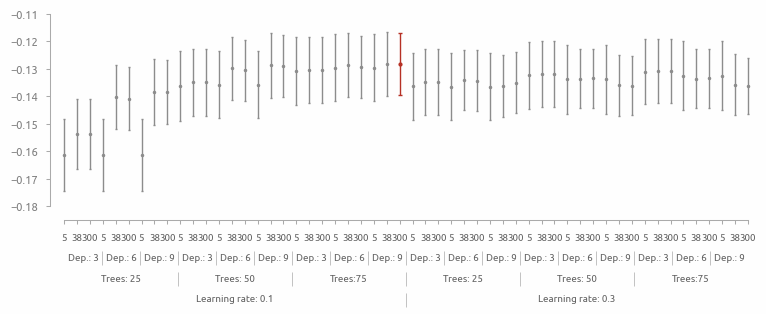

In [122]:
fig, ax = plt.subplots(figsize=(9, 2.5))

zip_ = [
    cv1_results_df.index, cv1_results_df['mean_test_score'],
    cv1_results_df['ci_margin'], cv1_results_df_colors
]
for x_, y_, ci_, c_ in zip(*zip_): 
    if x_ == cv1_results_df_best_score_idx:
        ax.errorbar(
            x=x_,
            y=y_,
            yerr=ci_,
            fmt='o',
            markersize=2,
            c=c_,
            linestyle='none',
            elinewidth=1,
            capsize=1.1,
            ecolor=c_,
            zorder=1,
        )
    else:
        ax.errorbar(
            x=x_,
            y=y_,
            yerr=ci_,
            fmt='o',
            markersize=1.5,
            c=c_,
            linestyle='none',
            elinewidth=1,
            capsize=1,
            ecolor=c_,
            zorder=1
        )
ax.set_xticks(ticks=arange(len(cv1_results_df)), labels=['5', '38', '300'] * 18)
axis_rstyle()

axis_add_xaxis(
    labels=[
        ['Dep.: 3', 'Dep.: 6', 'Dep.: 9'] * 6,
        ['Trees: 25', 'Trees: 50', 'Trees:75'] * 2,
        ['Learning rate: 0.1', 'Learning rate: 0.3']
    ],
    labelcolor='#606060'
)
savefig('gridsearch1', save_img)

In [123]:
best_params1 = cv1_results_df.loc[
    cv1_results_df.index==cv1_results_df_best_score_idx, 'params'
].item()

In [124]:
best_score1 = round(cv1_results_df_best_score, 4)

In [125]:
best_score1

-0.1282

In [126]:
best_params1

{'estimator__learning_rate': 0.1,
 'estimator__max_depth': 9,
 'estimator__n_estimators': 75,
 'estimator__num_leaves': 300,
 'estimator__random_state': 42,
 'estimator__verbose': -1}

### GridSearch Iteration #2

In [127]:
lgb2 = LGBMRegressor()

In [128]:
lgb_pipeline2 = Pipeline(steps=[
    ('encoder', encoder),
    ('estimator', lgb2)
])

In [129]:
learning_rate = [best_params1['estimator__learning_rate']]

max_depth_val = best_params1['estimator__max_depth']
max_depth = list(arange(max_depth_val-2, max_depth_val+3))

n_estimators_val = best_params1['estimator__n_estimators']
n_estimators = [n_estimators_val-5, n_estimators_val, n_estimators_val+5]

num_leaves_val = best_params1['estimator__num_leaves']
num_leaves = [num_leaves_val-15, num_leaves_val, num_leaves_val+15]

In [130]:
params2 = {
    'estimator__learning_rate': learning_rate,
    'estimator__max_depth': max_depth,
    'estimator__n_estimators': n_estimators,
    'estimator__num_leaves': num_leaves,
    'estimator__random_state': [seed],
    'estimator__verbose': [-1]
}

In [131]:
params2

{'estimator__learning_rate': [0.1],
 'estimator__max_depth': [7, 8, 9, 10, 11],
 'estimator__n_estimators': [70, 75, 80],
 'estimator__num_leaves': [285, 300, 315],
 'estimator__random_state': [42],
 'estimator__verbose': [-1]}

In [132]:
n_folds2 = 20

In [133]:
cv2 = GridSearchCV(
    estimator=lgb_pipeline2, 
    param_grid=params2,
    scoring='neg_root_mean_squared_error',
    cv=n_folds2
)

In [134]:
st = stopwatch.start()
cv2.fit(train_bm[features], train_bm[target])
print(f'Execution time: {stopwatch.stop(st)}')

Execution time: 0:05:32


In [135]:
cv2_results_df = pd.DataFrame(cv2.cv_results_)

In [136]:
cv2_results_df.shape

(45, 34)

In [137]:
cv2_results_df_columns_drop = [
    'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
]

In [138]:
cv2_results_df = cv2_results_df.loc[
    :, ~cv2_results_df.columns.isin(cv2_results_df_columns_drop)].copy()

In [139]:
cv2_results_df = cv2_results_df.sort_values([
    'param_estimator__learning_rate', 'param_estimator__n_estimators',
    'param_estimator__max_depth', 'param_estimator__num_leaves'
], ascending=True)

In [140]:
cv2_results_df = cv2_results_df.reset_index(drop=True)

In [141]:
# folds scores are normal
test_normality(cv2_results_df.iloc[0, 7:27].astype(float))

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),0.2939,Normal
2,Shapiro-Wilk,0.6072,Normal
3,Jarque-Bera,0.7430,Normal
4,D’Agostino-Pearson,0.7667,Normal


In [142]:
cv2_results_df['ci_margin'] = \
    1.96 * cv2_results_df['std_test_score'] / np.sqrt(n_folds1)

In [143]:
cv2_results_df_params_cols = [
    'param_estimator__learning_rate', 'param_estimator__n_estimators',
    'param_estimator__max_depth', 'param_estimator__num_leaves'
]

In [144]:
cv2_results_df.head()

,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__n_estimators,param_estimator__num_leaves,param_estimator__random_state,param_estimator__verbose,params,split0_test_score,split1_test_score,split2_test_score,...,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score,ci_margin
0,0.1,7,70,285,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.163877,-0.124761,-0.113160,...,-0.123605,-0.122667,-0.109503,-0.149767,-0.092091,-0.088229,-0.128808,0.025415,43,0.011139
1,0.1,7,70,300,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.163877,-0.124761,-0.113160,...,-0.123605,-0.122667,-0.109503,-0.149767,-0.092091,-0.088229,-0.128808,0.025415,43,0.011139
2,0.1,7,70,315,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.163877,-0.124761,-0.113160,...,-0.123605,-0.122667,-0.109503,-0.149767,-0.092091,-0.088229,-0.128808,0.025415,43,0.011139
3,0.1,8,70,285,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.164033,-0.127167,-0.113676,...,-0.117979,-0.123246,-0.104226,-0.152301,-0.086329,-0.085898,-0.127987,0.026969,16,0.011820
4,0.1,8,70,300,42,-1,"{'estimator__learning_rate': 0.1, 'estimator__...",-0.164033,-0.127167,-0.113676,...,-0.117979,-0.123246,-0.104226,-0.152301,-0.086329,-0.085898,-0.127987,0.026969,16,0.011820


In [145]:
# sort thw simplest model if several equal mean_test_scores
cv2_results_df_best_score_idx = \
    (cv2_results_df
     .sort_values(['param_estimator__n_estimators',
                   'param_estimator__max_depth',
                   'param_estimator__num_leaves'])
     .sort_values(['mean_test_score'], ascending=False)).iloc[0].name

In [146]:
cv2_results_df_best_score_idx

12

In [147]:
cv2_results_df_best_score = cv2_results_df.loc[
    cv2_results_df.index==cv2_results_df_best_score_idx, 'mean_test_score'
].item()

In [148]:
cv2_results_df_best_score_ci_margin = cv2_results_df.loc[
    cv2_results_df.index==cv2_results_df_best_score_idx, 'ci_margin'
].item()

In [149]:
len(cv2_results_df)

45

In [150]:
# define colors of pointplot's elements
cv2_results_df_colors = [palette[-4]] * 45
cv2_results_df_colors[cv2_results_df_best_score_idx] = '#B63125'

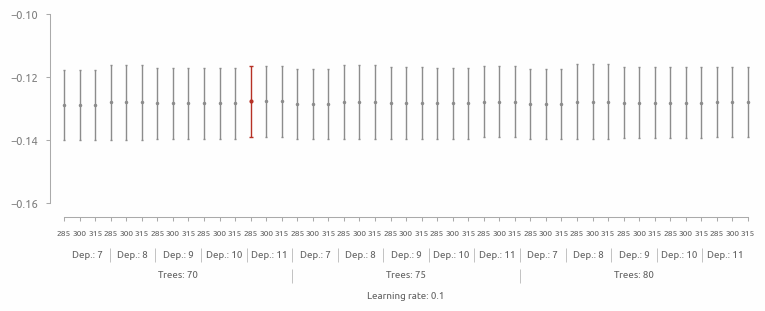

Images 'gridsearch2.png' and 'gridsearch2.svg' successfully saved into 'docs/img/Section1-Overview-and-Base-model' directory


In [151]:
fig, ax = plt.subplots(figsize=(9, 2.5))

zip_ = [
    cv2_results_df.index, cv2_results_df['mean_test_score'],
    cv2_results_df['ci_margin'], cv2_results_df_colors
]
for x_, y_, ci_, c_ in zip(*zip_): 
    if x_ == cv2_results_df_best_score_idx:
        ax.errorbar(
            x=x_,
            y=y_,
            yerr=ci_,
            fmt='o',
            markersize=2,
            c=c_,
            linestyle='none',
            elinewidth=1,
            capsize=1.1,
            ecolor=c_,
            zorder=1,
        )
    else:
        ax.errorbar(
            x=x_,
            y=y_,
            yerr=ci_,
            fmt='o',
            markersize=1.5,
            c=c_,
            linestyle='none',
            elinewidth=1,
            capsize=1,
            ecolor=c_,
            zorder=1
        )
ax.set_xticks(ticks=arange(len(cv2_results_df)), labels=['285', '300', '315']*15)
axis_rstyle(ylim=[-0.160, -0.099], yticks=[-0.160, -0.099, 0.020])


axis_add_xaxis(
    labels=[
        ['Dep.: 7', 'Dep.: 8', 'Dep.: 9', 'Dep.: 10', 'Dep.: 11'] * 3,
        ['Trees: 70', 'Trees: 75', 'Trees: 80'],
        ['Learning rate: 0.1']
    ],
    labelcolor='#606060'
)
ax.tick_params(axis='x', labelsize=6)
plt.show()

savefig('gridsearch2', save_img)

In [152]:
params_opt = cv2_results_df.loc[
    cv2_results_df.index==cv2_results_df_best_score_idx, 'params'
].item()

In [153]:
rmse_train_opt = round(cv2_results_df_best_score, 4)

In [154]:
rmse_train_opt

-0.1276

In [155]:
params_opt

{'estimator__learning_rate': 0.1,
 'estimator__max_depth': 11,
 'estimator__n_estimators': 70,
 'estimator__num_leaves': 285,
 'estimator__random_state': 42,
 'estimator__verbose': -1}

In [156]:
params = {}
for key in params_opt.keys():
    new_key = key.lstrip('estimator')
    new_key = new_key.lstrip('__')
    params[new_key] = params_opt[key]

In [157]:
params

{'learning_rate': 0.1,
 'max_depth': 11,
 'n_estimators': 70,
 'num_leaves': 285,
 'random_state': 42,
 'verbose': -1}

In [158]:
lgb_opt = LGBMRegressor(**params)

In [159]:
train_bm_opt = train_bm.copy()

In [160]:
train_bm_opt[features] = encoder.fit_transform(
    train_bm_opt[features], train_bm_opt[target])

In [161]:
train_bm_opt.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price
907,908,5,3,86.0,11500,1,2,1,1,1,...,0,0,3,2,0,6,2006,5,4,12.429216
782,783,10,3,67.0,16285,1,2,3,1,1,...,0,0,3,2,0,6,2009,5,4,12.139399
952,953,7,3,60.0,7200,1,2,0,1,1,...,0,0,2,2,0,4,2009,5,4,11.804849
620,621,0,3,45.0,8248,1,0,0,1,1,...,0,0,3,2,0,9,2008,5,4,11.112448
669,670,0,3,80.0,11600,1,2,0,1,1,...,0,0,3,2,0,7,2006,5,4,11.831379


In [162]:
lgb_opt.fit(train_bm_opt[features], train_bm_opt[target])

LGBMRegressor(max_depth=11, n_estimators=70, num_leaves=285, random_state=42,
              verbose=-1)

In [163]:
feature_importance = pd.DataFrame({
    'Feature': lgb_opt.feature_name_,
    'Importance': lgb_opt.feature_importances_
})
feature_importance.sort_values('Importance', ascending=False, inplace=True)

In [164]:
data_plot = feature_importance.loc[feature_importance['Importance']>0,:]
data_plot = data_plot.sort_values('Importance', ascending=False)

In [165]:
data_plot.head()

,Feature,Importance
13,grlivarea,236
2,lotarea,150
9,totalbsmtsf,132
6,bsmtfinsf_first,125
60,neighborhood,122


In [166]:
values = data_plot['Importance'][:10]
labels = data_plot['Feature'][:10]

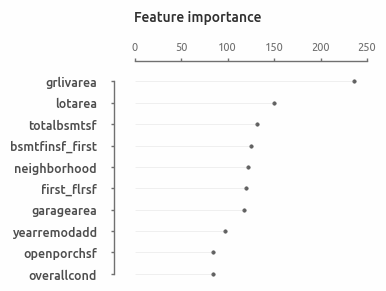

Images 'feature_importance.png' and 'feature_importance.svg' successfully saved into 'docs/img/Section1-Overview-and-Base-model' directory


In [167]:
fig = plot_bar_horizontal(
    values=values,
    labels=labels,
    labelsize=9,
    labelcolor='0.3',
    labelweight='medium',
    figsize=(3, 2.5),
    kind='lol',
    width=0.5,
    s=6,
    x_lim_right=250
)
savefig('feature_importance', save_img)

## Save Data

In [168]:
datasets_dict = {
    'train_raw': train_raw,
    'train': train,
    'test': test
}

In [169]:
features_dict = {
    'features': features,
    'numeric': numeric,
    'ordinal': ordinal,
    'categorical': categorical,
    'categorical_transform': categorical_transform,
    'target': target
}

In [170]:
transform_dict = {
    'features_na': features_na,
    'transformer_overview': transformer_overview,
    'transformer_imputer_frequent': imputer_frequent,
    'transformer_imputer_median': imputer_median,
    'transformer_label': transformer_label,
}

In [171]:
simulation_datasets_dict = {
    'train_base': train_bm,
    'features_base': features
}

In [172]:
estimators_dict = {'lgb_base': lgb_opt}

In [173]:
evaluation_dict = {'cv_base': cv2}

In [174]:
saveit(datasets_dict, 'datasets_dict', save_files)

In [175]:
saveit(features_dict, 'features_dict', save_files)

In [176]:
saveit(transform_dict, 'transform_dict', save_files)

In [177]:
saveit(simulation_datasets_dict, 'simulation_datasets_dict', save_files)

In [178]:
saveit(estimators_dict, 'estimators_dict', save_files)

In [179]:
saveit(evaluation_dict, 'evaluation_dict', save_files)

In [180]:
saveit(params, 'params', save_files)

In [181]:
saveit(feature_importance, 'feature_importance', save_files)

### Save Session

In [182]:
save_session(session_name)

### Execution time

In [183]:
print(f'Execution time: {stopwatch.stop(start)}')

Execution time: 0:10:25
